This colab contains a Data_set wich gathers 90% of the total transactions. This means that only 74 Merchants were taken.


# Modules

In [2]:
import pandas as pd
import numpy as np
from google.colab import drive
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import StandardScaler
from math import sqrt
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from numpy import array
import matplotlib.pyplot as plt
import os
import seaborn as sns

# Loading data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
ninety = '/content/drive/MyDrive/07 - Six - Colab Notebooks/Processed data/ninety.csv'
ninety_sum = '/content/drive/MyDrive/07 - Six - Colab Notebooks/Processed data/ninety_sum.csv'
all =  '/content/drive/MyDrive/07 - Six - Colab Notebooks/Raw data copy/Time_Series_Merchants_Transactions_Anonymized.csv'

In [5]:
sum_test = '/content/drive/MyDrive/07 - Six - Colab Notebooks/Processed data/betka_tests_tmp/test_sum.csv'
prediction = '/content/drive/MyDrive/07 - Six - Colab Notebooks/Processed data/auto_arima_results_total_with_train_test_output/data_predictions.csv'

In [7]:
df_90 = pd.read_csv(ninety)
df = pd.read_csv(ninety_sum)
df_total = pd.read_csv(all)
df.columns = ['Date', 'Transactions']
df.Date = pd.Series(pd.period_range("8/1/2020", freq="M", periods=26))

# Functions

In [33]:
def plot(fit1):
  simulations = fit1.simulate(12, repetitions=100, error="mul")
  ax = data.plot(
      figsize=(10, 6),
      marker="o",
      color="black",
      title="Forecasts and simulations from Holt-Winters'",
  )
  ax.set_ylabel("Nº of Transactions")
  ax.set_xlabel("Year")
  fit1.fittedvalues.plot(ax=ax, style="--", color="green")
  simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
  fit1.forecast(8).rename("Holt-Winters (add-mul-seasonal)").plot(
      ax=ax, style="--", marker=">", color="green", legend=True
  )
  plt.show()
  return simulations

def exp_smoothing_forecast(history, config):
    t, d, s, p, b, r, sm = config
    history = array(history)
    model = ExponentialSmoothing(history, trend=t, damped_trend=d, seasonal=s, seasonal_periods=p)
    model_fit = model.fit(smoothing_level=sm, optimized=True, remove_bias=r)
    yhat = model_fit.predict(len(history), len(history))
    return yhat[0]

# See if we can do the same with the rest of models
def train_test_split(data, n_test):
    return data[:-n_test], data[-n_test:]

# Straightforward function to mesure RMSE
def measure_rmse(actual, predicted):
    return sqrt(mean_squared_error(actual, predicted))


def walk_forward_validation(data, n_test, cfg):
    predictions = list()
    train, test = train_test_split(data, n_test)
    history = [x for x in train]
    for i in range(len(test)):
        yhat = exp_smoothing_forecast(history, cfg)
        predictions.append(yhat)
        history.append(test[i])
    error = measure_rmse(test, predictions)
    return error

#Scoring the model
def score_model(data, n_test, cfg, debug=False): #
    result = None
    key = str(cfg)
    if debug:
        result = walk_forward_validation(data, n_test, cfg)
    else:
        try:
            #with catch_warnings():
                #filterwarnings("ignore")
            result = walk_forward_validation(data, n_test, cfg)
        except:
            error = None
    #if result is not None:
        #print(' > Model[%s] %.3f' % (key, result))
    return (key, result)

# grid-search --> getting the model with the lowest error
def grid_search(data, cfg_list, n_test, parallel=False):
    scores = None
    if parallel:
        #execute configs in parallel
        executor = Parallel(n_jobs=cpu_count(), backend='multiprocessing')
        tasks = (delayed(score_model)(data, n_test, cfg) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(data, n_test, cfg) for cfg in cfg_list]
    #remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# Configurations to train
def exp_smoothing_configs(seasonal=[0 ,4, 6, 8, 12]):
    models = list()
    # define config lists
    t_params = ['add', 'mul', None]
    d_params = [True, False]
    s_params = ['add', 'mul', None]
    p_params = seasonal
    b_params = [True, False]
    r_params = [True, False]
    sm_params = [0.1, 0.25, 0.5, 0.75, 1]
    # create config instances
    for t in t_params:
        for d in d_params:
            for s in s_params:
                for p in p_params:
                    for b in b_params:
                        for r in r_params:
                            for sm in sm_params:
                                cfg = [t, d, s, p, b, r, sm]
                                models.append(cfg)
    return models

# Extracting the best (lowest error) configuration as a list to run the model --- > it returns the "RMSE"
def run_ETS_get_rmse(df, n_test=5):
    list_s = "][' "
    cfg_list = exp_smoothing_configs()
    scores = grid_search(data, cfg_list, n_test)
    #print('done')
    for cfg, error in scores[:1]:
        #print(cfg, 'RMSE = ', error)
        for i in list_s:
            cfg = cfg.replace(i, '')
        cfg1= cfg.split(',')
    for i, n in enumerate(cfg1):
        if n == 'False':
            cfg1[i] = False
        elif n == 'True':
            cfg1[i] = True
        try:
            float(n)
            cfg1[i] = float(n)
            result = True
        except:
            continue
    return cfg1, error

# modeling + fitting
def modeling_ETS(data, cfg):
    t, d, s, s_p, bx, b, sm = cfg
    model = ExponentialSmoothing(data, trend=t, damped_trend=d, seasonal=s, seasonal_periods=s_p)
    fit = model.fit(smoothing_level=sm,use_boxcox=bx, remove_bias=b)
    return model, fit

#Drawing the boundaries for plotting
def boundaries(simulations):
    simulations_tr = simulations.transpose(copy=True)
    simulations_tr_summary = simulations_tr.describe(percentiles=[.025, .5, .975])
    simulations_summary = simulations_tr_summary.transpose(copy=True)
    y1 = simulations_summary['2.5%']
    y2 = simulations_summary['97.5%']
    x = simulations_summary.index
    CI_ETS = pd.concat([y1, y2], axis=1)
    return y1, y2, x

def predictions(data, cfg, num_sim=12):
  _, fit = modeling_ETS(data, cfg)
  fitted = pd.DataFrame(fit.fittedvalues, columns=['Transactions'])
  CI_fitted = fit.simulate(nsimulations=data.shape[0],
                            repetitions=1000,
                            anchor='start'
                            )
  columns_1=['fitted', 'lower_bound', 'upper_bound']
  columns_2=['predicted', 'lower_bound', 'upper_bound']
  upper_ci = CI_fitted.quantile(q=0.975, axis='columns')
  lower_ci = CI_fitted.quantile(q=0.025, axis='columns')
  CI_fitted = pd.concat([lower_ci, upper_ci], axis=1)
  dp = [fitted, CI_fitted]
  df_fitted = pd.concat(dp, join='inner', axis=1)
  df_fitted.columns = columns_1

  simulations = fit.simulate(num_sim, repetitions=1000, error="mul")
  predictions = fit.forecast(num_sim)
  CI_predictions = boundaries(simulations)
  ds = [predictions, CI_predictions]
  df_merchant_transactions_concat = pd.concat(ds, join='inner', axis=1)
  df_merchant_transactions_concat.columns = columns_2
  return predictions, CI_predictions, fitted, CI_fitted, df_merchant_transactions_concat, df_fitted

# Plotting the ETS model
def plot_simulation(data, cfg):
    model, fit = modeling_ETS(data, cfg)
    simu = fit.simulate(12, anchor="end", repetitions=1000, error="mul")
    y1, y2, x = boundaries(simu)
    ax = data.plot(
        figsize=(10, 6),
        marker="o",
        color="black",
        title='Forecasting and Simulations ETS',
        label='Sum of all Merchants'
    )
    ax.set_ylabel("Nº of Transactions ")  # Nº of Transactions
    ax.set_xlabel("Year")  # Year
    fit.fittedvalues.plot(ax=ax, style="--", color="green")
    ax.fill_between(x, y1, y2, alpha=0.2, color='g', animated=True)
    fit.forecast(12).rename('ETS Forecasting').plot(
        ax=ax, style="--", marker=">", color="green", legend=True
    )

# Transforming data

In [10]:
rn = ['Date', 'Transactions']
df.columns = rn
df_ser = df.set_index('Date')
df_ser= df_ser.squeeze()

In [11]:
df_90 = df_90.set_index('Merchant Name')
df_90.columns = pd.Series(pd.period_range("8/1/2020", freq="M", periods=26))

# Hyperarameter tunning

In [12]:
data = df_ser
n_test = 5
#cfg_list = exp_smoothing_configs()
#scores = grid_search(data, cfg_list, n_test)
#for cfg, error in scores[:3]:
  #print(cfg, 'RMSE = ', error)

In [13]:
cfg1, error_1 = run_ETS_get_rmse(data, n_test)

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:

In [14]:
cfg1, error_1
#t, d, s, p, r, b, sm = ['mul', False, 'mul', 12, False, False, 0.25]

(['mul', False, 'mul', 12.0, True, False, 0.25], 320252.38289701345)

Results

['mul', False, 'mul', 12, True, False, 0.25] --> RSME = 320252.38289701345

['add', False, None, 0, True, True, 0.1] --> RSME = 556144.2436811397

# Modelling

In [15]:
model1, fit1 = modeling_ETS(data, cfg1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,


In [16]:
df = pd.DataFrame(fit1.forecast(12))
df.columns = ['Predictions']
df.to_csv('ETS_pred_74.csv')

In [17]:
model2 = ExponentialSmoothing(data, trend='add', damped_trend=False, seasonal=None,seasonal_periods=0)
fit2 = model2.fit(smoothing_level=0.10, use_boxcox=True, remove_bias=True)

# Forecasting

In [18]:
fit1.forecast(12)

2022-10    6.723469e+06
2022-11    7.551226e+06
2022-12    8.743845e+06
2023-01    7.267538e+06
2023-02    7.813473e+06
2023-03    7.510532e+06
2023-04    7.140633e+06
2023-05    8.752328e+06
2023-06    7.648924e+06
2023-07    7.433746e+06
2023-08    8.434393e+06
2023-09    8.198196e+06
Freq: M, dtype: float64

## Simple plotting (Data set + prediction)

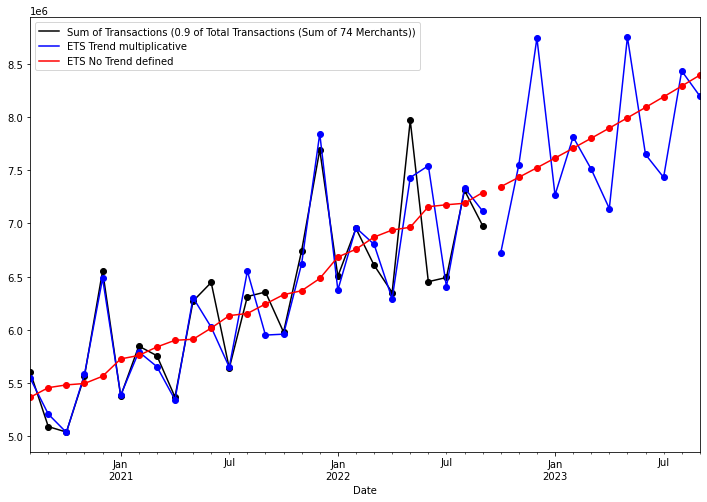

In [24]:
fcast1 = fit1.forecast(12).rename("ETS Trend multiplicative")
fcast2 = fit2.forecast(12).rename("ETS No Trend defined")


ax = data.plot(marker='o', color='black', figsize=(12,8), label='Sum of Transactions (0.9 of Total Transactions (Sum of 74 Merchants))')
ax.legend()
fcast1.plot(marker='o', ax=ax, color='blue', legend=True)
fit1.fittedvalues.plot(marker='o', ax=ax, color='blue')
fcast2.plot(marker='o', ax=ax, color='red', legend=True)
fit2.fittedvalues.plot(marker='o', ax=ax, color='red')
plt.show()

## Simulation + Forcasting + Data set

In [25]:
simulations = fit1.simulate(12, anchor="end", repetitions=1000, error="mul")
simulations_2 = fit2.simulate(12, anchor="end", repetitions=1000, error="mul")

In [26]:
boundaries(simulations)

(2022-10    5.902793e+06
 2022-11    6.575715e+06
 2022-12    7.565346e+06
 2023-01    6.278424e+06
 2023-02    6.741764e+06
 2023-03    6.430737e+06
 2023-04    6.084761e+06
 2023-05    7.402479e+06
 2023-06    6.486058e+06
 2023-07    6.181230e+06
 2023-08    7.121036e+06
 2023-09    6.800209e+06
 Freq: M, Name: 2.5%, dtype: float64, 2022-10    7.717654e+06
 2022-11    8.695234e+06
 2022-12    1.009310e+07
 2023-01    8.546865e+06
 2023-02    9.156988e+06
 2023-03    8.904039e+06
 2023-04    8.422021e+06
 2023-05    1.035460e+07
 2023-06    9.035971e+06
 2023-07    8.964156e+06
 2023-08    1.018993e+07
 2023-09    9.808568e+06
 Freq: M, Name: 97.5%, dtype: float64, PeriodIndex(['2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
              '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09'],
             dtype='period[M]'))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:1116: FutureWarning: Setting use_boxcox during fit has been deprecated and will be removed after 0.13. It must be set during model initialization.
  FutureWarning,


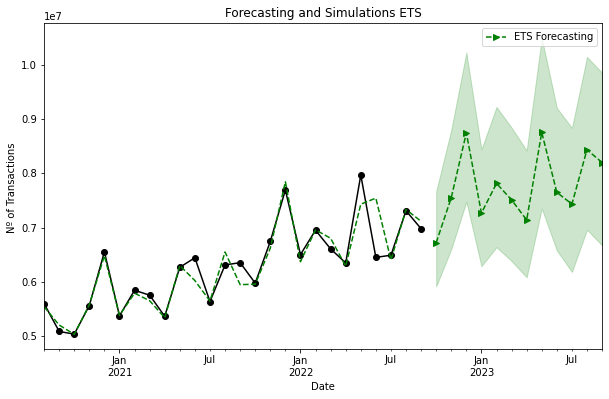

In [34]:
plot_simulation(data, cfg1)

In [30]:
simulations_tr = simulations.transpose(copy=True)
simulations_tr_summary = simulations_tr.describe(percentiles=[.025, .5, .975])
simulations_summary = simulations_tr_summary.transpose(copy=True)
y1 = simulations_summary['2.5%']
y2 = simulations_summary['97.5%'] 
x = simulations_summary.index

In [31]:
simulations_tr_2 = simulations_2.transpose(copy=True)
simulations_2_tr_summary = simulations_tr_2.describe(percentiles=[.025, .5, .975])
simulations_2_summary = simulations_2_tr_summary.transpose(copy=True)
y3 = simulations_2_summary['2.5%']
y4 = simulations_2_summary['97.5%'] 
x2 = simulations_2_summary.index

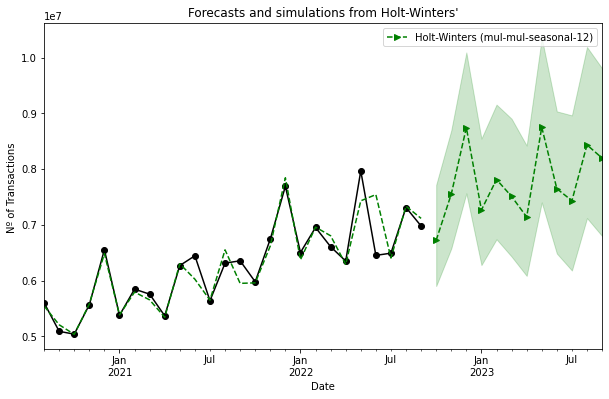

In [35]:
# plotting simulations
simulations = fit1.simulate(12, repetitions=1000, error="mul")
simulations_2 = fit2.simulate(12, repetitions=1000, error="mul")
x = simulations.index
x1 = pd.date_range(start='2020-08', end='2022-09', freq="M")
ax = data.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters'",
    label = 'Sum of all Merchants'
)
ax.set_ylabel("Nº of Transactions ")
ax.set_xlabel("Year")
fit1.fittedvalues.plot(ax=ax, style="--", color="green")
ax.fill_between(x, y1, y2, alpha=0.2, color='g', animated=True)
fit1.forecast(12).rename("Holt-Winters (mul-mul-seasonal-12)").plot(
    ax=ax, style="--", marker=">", color="green", legend=True
)
plt.show()

# Training individually for one Merchant without trend but with a strong seasonality

In [37]:
data_1 = df_90.iloc[73]
model3 = ExponentialSmoothing(data_1, trend='mul', damped_trend=False, seasonal='mul',seasonal_periods=12)
fit3 = model3.fit(smoothing_level=0.25)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:80: RuntimeWarning: overflow encountered in matmul
  return err.T @ err
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:922: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


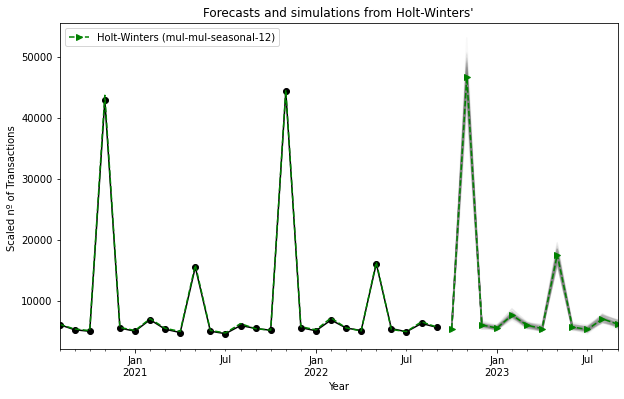

In [38]:
simulations = fit3.simulate(12, repetitions=100, error="mul")
ax = data_1.plot(
    figsize=(10, 6),
    marker="o",
    color="black",
    title="Forecasts and simulations from Holt-Winters'",
    label = 'Sum of all Merchants'
)
ax.set_ylabel("Scaled nº of Transactions ")
ax.set_xlabel("Year")
fit3.fittedvalues.plot(ax=ax, style="--", color="green")
simulations.plot(ax=ax, style="-", alpha=0.05, color="grey", legend=False)
fit3.forecast(12).rename("Holt-Winters (mul-mul-seasonal-12)").plot(
    ax=ax, style="--", marker=">", color="green", legend=True
)
plt.show()